In [1]:
# import initial libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox 
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot

In [2]:
raw_df = pd.read_csv('zillow_data.csv')

In [3]:
raw_df = raw_df[raw_df['State']=='TX']
raw_df.drop(raw_df.columns[np.r_[0,3,4, 6:100]], axis=1, inplace=True)
raw_df = raw_df.rename(columns={'RegionName': 'zipcode'})

In [4]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['2004-01'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'2004-01':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'2004-01':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
raw_df['CV']=raw_df['std']/raw_df['mean']

#Show calculated values
raw_df[['zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(raw_df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = raw_df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = raw_df[raw_df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV']]

count    989.000000
mean       0.121449
std        0.036183
min        0.019827
25%        0.098176
50%        0.120857
75%        0.142168
max        0.293064
Name: CV, dtype: float64

CV upper limit: 0.12848011113068844

 Best 5 Zipcodes:


,zipcode,ROI,CV
9851,76050,0.943470,0.117471
7776,78204,0.848754,0.119656
11091,77514,0.845737,0.126108
2901,77550,0.843943,0.120857
4807,79602,0.830396,0.124068


In [5]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['zipcode', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167292 entries, 0 to 170107
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   zipcode     167292 non-null  int64         
 1   City        167292 non-null  object        
 2   CountyName  167292 non-null  object        
 3   ROI         162884 non-null  float64       
 4   std         167292 non-null  float64       
 5   mean        167292 non-null  float64       
 6   CV          167292 non-null  float64       
 7   date        167292 non-null  datetime64[ns]
 8   value       167292 non-null  float64       
 9   year        167292 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 14.0+ MB


In [7]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
2004-01-01,75070,McKinney,Collin,0.714438,38257.775512,227040.116279,0.168507,187700.0,2004
2004-01-01,77494,Katy,Harris,0.423210,33208.367605,266633.139535,0.124547,231800.0,2004
2004-01-01,79936,El Paso,El Paso,0.446429,10248.462666,113729.651163,0.090112,84000.0,2004
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [8]:
df_income = pd.read_csv('zip_codes_2019_median_inc.csv')
df_income['state'] = df_income['Preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['Type'] != 'PO box'])
df_income

,ZIP Code,Type,State FIPS,Preferred name,Alternate names,Population (2019),Housing units (2019),Median family income (2019),MFI percentile (2019),Latitude,Longitude,Land area,Water area,state
31142,73301,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31143,73344,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31744,75001,standard,48,"Addison, TX",NaN,"14,992","9,298","$79,551",68.0,32.959999,-96.838997,3.834,0.003,TX
31745,75002,standard,48,"Allen, TX","Lucas, Parker","71,253","23,314","$105,656",88.0,33.090000,-96.609001,37.179,2.056,TX
31746,75006,standard,48,"Carrollton, TX",NaN,"51,642","19,178","$72,325",57.0,32.962002,-96.899002,16.875,0.254,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34257,79961,unique,48,"El Paso, TX",El Paso Water Utilities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
34258,79968,unique,48,"El Paso, TX",Univ Of Tx Elp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
34259,79976,unique,48,"El Paso, TX",Southern Union Gas Co,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
34260,79978,unique,48,"El Paso, TX",El Paso Natural Gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX


In [9]:
df_income = df_income.rename(columns={'Population (2019)': 'population', 
                        'Housing units (2019)': 'housing_units',
                         'ZIP Code': 'zipcode'})

In [10]:
df_income['Median family income (2019)'] = df_income['Median family income (2019)'].str.strip('$\n\t')
df_income['Median family income (2019)'] = df_income['Median family income (2019)'].str.replace(',','')
df_income = df_income[df_income['Median family income (2019)'].notna()]
df_income['median_family_income'] = df_income['Median family income (2019)'].astype(int)

In [11]:
df_income.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zipcode                      1623 non-null   int64  
 1   Type                         1623 non-null   object 
 2   State FIPS                   1623 non-null   int64  
 3   Preferred name               1623 non-null   object 
 4   Alternate names              689 non-null    object 
 5   population                   1623 non-null   object 
 6   housing_units                1623 non-null   object 
 7   Median family income (2019)  1623 non-null   object 
 8   MFI percentile (2019)        1623 non-null   float64
 9   Latitude                     1623 non-null   float64
 10  Longitude                    1623 non-null   float64
 11  Land area                    1623 non-null   float64
 12  Water area                   1623 non-null   float64
 13  state        

In [12]:
df_income.drop(df_income.columns[np.r_[1:5,7,8,11,12]], axis=1, inplace=True)

In [13]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   object 
 2   housing_units         1623 non-null   object 
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
 6   median_family_income  1623 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 101.4+ KB


In [14]:
# df_merged = df.merge(df_income, on ='zipcode')
df_merged = df.reset_index().merge(df_income, how="left").set_index('date')
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income
date,,,,,,,,,,,,,,,
2004-01-01,75070,McKinney,Collin,0.714438,38257.775512,227040.116279,0.168507,187700.0,2004,"104,415","38,662",33.172001,-96.695999,TX,115530.0
2004-01-01,77494,Katy,Harris,0.423210,33208.367605,266633.139535,0.124547,231800.0,2004,"118,291","38,449",29.740999,-95.830002,TX,148843.0
2004-01-01,79936,El Paso,El Paso,0.446429,10248.462666,113729.651163,0.090112,84000.0,2004,"111,620","37,267",31.777000,-106.296997,TX,61016.0
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004,"107,673","37,968",29.827000,-95.660004,TX,70460.0
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004,"128,294","38,672",29.837999,-95.734001,TX,82716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,"1,455",783,31.271999,-100.889000,TX,64464.0
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,"1,528",744,33.805000,-102.162003,TX,49250.0
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018,"1,877",738,33.181999,-102.876999,TX,64563.0


In [15]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [16]:
df_merged['affordability'] = df_merged['value'] - df_merged['median_family_income']/.12
df_merged['affordability'] = NormalizeData(df_merged['affordability'])
df_merged['affordability_score'] = (df_merged['affordability'] - df_merged['affordability'].mean())/df_merged['affordability'].std()
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2004-01-01,75070,McKinney,Collin,0.714438,38257.775512,227040.116279,0.168507,187700.0,2004,"104,415","38,662",33.172001,-96.695999,TX,115530.0,0.488776,-1.428895
2004-01-01,77494,Katy,Harris,0.423210,33208.367605,266633.139535,0.124547,231800.0,2004,"118,291","38,449",29.740999,-95.830002,TX,148843.0,0.360612,-2.617735
2004-01-01,79936,El Paso,El Paso,0.446429,10248.462666,113729.651163,0.090112,84000.0,2004,"111,620","37,267",31.777000,-106.296997,TX,61016.0,0.681198,0.355999
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004,"107,673","37,968",29.827000,-95.660004,TX,70460.0,0.657432,0.135550
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004,"128,294","38,672",29.837999,-95.734001,TX,82716.0,0.603845,-0.361522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,"1,455",783,31.271999,-100.889000,TX,64464.0,0.686064,0.401141
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,"1,528",744,33.805000,-102.162003,TX,49250.0,0.723652,0.749805
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018,"1,877",738,33.181999,-102.876999,TX,64563.0,0.670189,0.253878


In [17]:
# Select the first quantile
q1 = df['value'].quantile(.25)

# Select the third quantile
q3 = df['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df[(df['value']>=q1) 
             & (df['value']<=q3)]
filtered

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004
2004-01-01,78660,Pflugerville,Travis,0.578674,23031.089035,180093.023256,0.127884,153800.0,2004
2004-01-01,77573,League City,Galveston,0.568086,23867.673325,199441.279070,0.119673,166700.0,2004
2004-01-01,79912,El Paso,El Paso,0.476452,13149.347629,171614.534884,0.076621,127400.0,2004
...,...,...,...,...,...,...,...,...,...
2018-04-01,76064,Maypearl,Ellis,0.659048,15308.985812,136593.604651,0.112077,174200.0,2018
2018-04-01,77577,Liverpool,Brazoria,0.761511,17597.138719,108870.348837,0.161634,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.312721,11184.253614,131325.581395,0.085164,148600.0,2018


In [18]:
df_merged['population'] = df_merged['population'].str.strip(',')
df_merged['population'] = df_merged['population'].str.replace(',','')
df_merged = df_merged[df_merged['population'].notna()]
df_merged['population'] = df_merged['population'].astype(int)
df_merged

<ipython-input-18-6051d07dd1a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['population'] = df_merged['population'].astype(int)


,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2004-01-01,75070,McKinney,Collin,0.714438,38257.775512,227040.116279,0.168507,187700.0,2004,104415,"38,662",33.172001,-96.695999,TX,115530.0,0.488776,-1.428895
2004-01-01,77494,Katy,Harris,0.423210,33208.367605,266633.139535,0.124547,231800.0,2004,118291,"38,449",29.740999,-95.830002,TX,148843.0,0.360612,-2.617735
2004-01-01,79936,El Paso,El Paso,0.446429,10248.462666,113729.651163,0.090112,84000.0,2004,111620,"37,267",31.777000,-106.296997,TX,61016.0,0.681198,0.355999
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004,107673,"37,968",29.827000,-95.660004,TX,70460.0,0.657432,0.135550
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004,128294,"38,672",29.837999,-95.734001,TX,82716.0,0.603845,-0.361522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,77577,Liverpool,Brazoria,0.761511,17597.138719,108870.348837,0.161634,149200.0,2018,1481,719,29.284000,-95.281998,TX,76382.0,0.646702,0.036017
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,1455,783,31.271999,-100.889000,TX,64464.0,0.686064,0.401141
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,1528,744,33.805000,-102.162003,TX,49250.0,0.723652,0.749805


In [19]:
df_merged['affordability_score']

date
2004-01-01   -1.428895
2004-01-01   -2.617735
2004-01-01    0.355999
2004-01-01    0.135550
2004-01-01   -0.361522
                ...   
2018-04-01    0.036017
2018-04-01    0.401141
2018-04-01    0.749805
2018-04-01    0.253878
2018-04-01   -1.043447
Name: affordability_score, Length: 165400, dtype: float64

In [20]:
# Select the first quantile
q1 = df['value'].quantile(.25)

# Select the third quantile
q3 = df['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df[(df['value']>=q1) 
             & (df['value']<=q3)]
filtered

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004
2004-01-01,78660,Pflugerville,Travis,0.578674,23031.089035,180093.023256,0.127884,153800.0,2004
2004-01-01,77573,League City,Galveston,0.568086,23867.673325,199441.279070,0.119673,166700.0,2004
2004-01-01,79912,El Paso,El Paso,0.476452,13149.347629,171614.534884,0.076621,127400.0,2004
...,...,...,...,...,...,...,...,...,...
2018-04-01,76064,Maypearl,Ellis,0.659048,15308.985812,136593.604651,0.112077,174200.0,2018
2018-04-01,77577,Liverpool,Brazoria,0.761511,17597.138719,108870.348837,0.161634,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.312721,11184.253614,131325.581395,0.085164,148600.0,2018


In [21]:
top_20 = df_merged['affordability_score'].quantile(.2)
df_merged_20 = df_merged[(df_merged['affordability_score'] <top_20) 
                      & (df_merged['year']==2018) ]
df_merged_20

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2018-01-01,75070,McKinney,Collin,0.714438,38257.775512,227040.116279,0.168507,318100.0,2018,104415,"38,662",33.172001,-96.695999,TX,115530.0,0.560347,-0.765001
2018-01-01,77494,Katy,Harris,0.423210,33208.367605,266633.139535,0.124547,321200.0,2018,118291,"38,449",29.740999,-95.830002,TX,148843.0,0.409680,-2.162581
2018-01-01,77573,League City,Galveston,0.568086,23867.673325,199441.279070,0.119673,254700.0,2018,88131,"31,342",29.504000,-95.086998,TX,121943.0,0.496217,-1.359866
2018-01-01,77584,Pearland,Brazoria,0.433762,21811.667986,202840.697674,0.107531,251900.0,2018,90372,"32,487",29.545000,-95.350998,TX,126143.0,0.475470,-1.552314
2018-01-01,78613,Cedar Park,Williamson,0.699828,33509.601183,219186.046512,0.152882,295900.0,2018,81943,"28,334",30.504000,-97.823997,TX,115556.0,0.548044,-0.879129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,75496,Wolfe City,Hunt,-0.022667,4595.412591,63780.813953,0.072050,73300.0,2018,3739,"1,567",33.349998,-96.057999,TX,85093.0,0.565200,-0.719986
2018-04-01,77534,Danbury,Brazoria,0.592271,14298.772296,128727.906977,0.111077,164800.0,2018,2256,961,29.232000,-95.314003,TX,107262.0,0.514023,-1.194699
2018-04-01,79068,Panhandle,Carson,0.436170,8638.032976,86950.581395,0.099344,108000.0,2018,3489,"1,483",35.347000,-101.444000,TX,99922.0,0.516420,-1.172467


In [22]:
#Descriptive statistics of coefficients of variance.
print(df_merged_20.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_merged_20.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = df_merged_20[df_merged_20['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:25]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV', 'affordability']]

count    552.000000
mean       0.128310
std        0.024654
min        0.071307
25%        0.111876
50%        0.125307
75%        0.144036
max        0.198133
Name: CV, dtype: float64

CV upper limit: 0.13105324464663523

 Best 5 Zipcodes:


,zipcode,ROI,CV,affordability
date,,,,
2018-03-01,77523,0.772476,0.127942,0.504427
2018-01-01,77523,0.772476,0.127942,0.502232
2018-04-01,77523,0.772476,0.127942,0.505086
2018-02-01,77523,0.772476,0.127942,0.503330
2018-02-01,75167,0.762112,0.128137,0.566948
2018-03-01,75167,0.762112,0.128137,0.568923
2018-01-01,75167,0.762112,0.128137,0.565301
2018-01-01,79124,0.759485,0.110003,0.496794
2018-02-01,79124,0.759485,0.110003,0.497233


In [23]:
zipcode =[77523, 75167, 79124, 78731, 78248]
df_merged = df_merged[df_merged['zipcode'].isin(zipcode)]
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2004-01-01,78731,Austin,Travis,0.679043,55045.738792,463633.720930,0.118727,363600.0,2004,27298,"13,665",30.348000,-97.767998,TX,146290.0,0.444629,-1.838398
2004-01-01,77523,Baytown,Harris,0.772476,24757.712506,193507.558140,0.127942,144600.0,2004,23501,"7,997",29.790001,-94.859001,TX,120196.0,0.443778,-1.846289
2004-01-01,78248,San Antonio,Bexar,0.667883,34811.986801,280319.186047,0.124187,219200.0,2004,14345,"5,705",29.590000,-98.525002,TX,149544.0,0.350490,-2.711625
2004-01-01,79124,Amarillo,Potter,0.759485,23536.963300,213967.441860,0.110003,147600.0,2004,8800,"3,574",35.266998,-101.958000,TX,121901.0,0.437626,-1.903353
2004-01-01,75167,Waxahachie,Ellis,0.762112,25133.401297,196144.186047,0.128137,161000.0,2004,12170,"3,907",32.361000,-96.916000,TX,109059.0,0.503719,-1.290286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78731,Austin,Travis,0.679043,55045.738792,463633.720930,0.118727,610500.0,2018,27298,"13,665",30.348000,-97.767998,TX,146290.0,0.580143,-0.581378
2018-04-01,77523,Baytown,Harris,0.772476,24757.712506,193507.558140,0.127942,256300.0,2018,23501,"7,997",29.790001,-94.859001,TX,120196.0,0.505086,-1.277601
2018-04-01,78248,San Antonio,Bexar,0.667883,34811.986801,280319.186047,0.124187,365600.0,2018,14345,"5,705",29.590000,-98.525002,TX,149544.0,0.430843,-1.966272


In [24]:
df = pd.DataFrame(filtered)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
2004-01-01,77084,Houston,Harris,0.376047,14170.210695,130143.604651,0.108881,119400.0,2004
2004-01-01,77449,Katy,Harris,0.422115,16508.811448,134945.348837,0.122337,123900.0,2004
2004-01-01,78660,Pflugerville,Travis,0.578674,23031.089035,180093.023256,0.127884,153800.0,2004
2004-01-01,77573,League City,Galveston,0.568086,23867.673325,199441.279070,0.119673,166700.0,2004
2004-01-01,79912,El Paso,El Paso,0.476452,13149.347629,171614.534884,0.076621,127400.0,2004
...,...,...,...,...,...,...,...,...,...
2018-04-01,76064,Maypearl,Ellis,0.659048,15308.985812,136593.604651,0.112077,174200.0,2018
2018-04-01,77577,Liverpool,Brazoria,0.761511,17597.138719,108870.348837,0.161634,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.312721,11184.253614,131325.581395,0.085164,148600.0,2018


In [25]:
# df.drop(df.columns[np.r_[9:18,20,21]], axis=1, inplace=True)

In [26]:
df_merged['median_family_income'].isna().sum()

0

In [27]:
df_prices = pd.DataFrame(df_merged['value'], index = df_merged.index)
df_prices

,value
date,
2004-01-01,363600.0
2004-01-01,144600.0
2004-01-01,219200.0
2004-01-01,147600.0
2004-01-01,161000.0
...,...
2018-04-01,610500.0
2018-04-01,256300.0
2018-04-01,365600.0


<AxesSubplot:xlabel='date'>

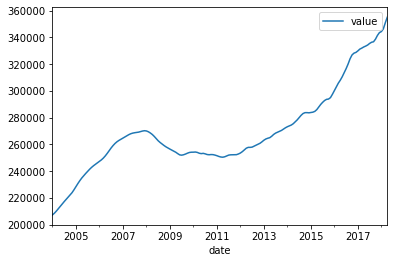

In [28]:
avg_prices = df_prices.groupby('date').aggregate({'value':'mean'})
avg_prices.plot()

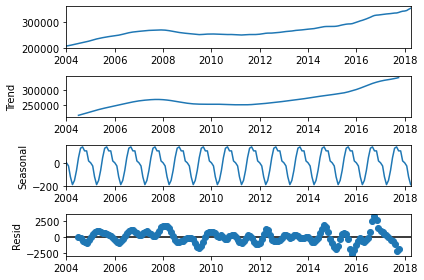

In [29]:
seasonal_avg = seasonal_decompose(avg_prices, model='additive')
seasonal_avg.plot()
pyplot.show()

<AxesSubplot:xlabel='date'>

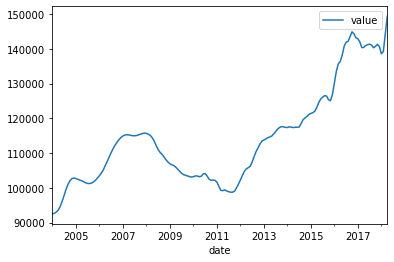

In [30]:
std_prices = df_prices.groupby('date').aggregate({'value':'std'})
std_prices.plot()

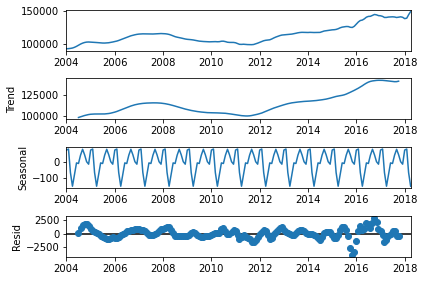

In [31]:
seasonal_std = seasonal_decompose(std_prices, model='additive')
seasonal_std.plot()
pyplot.show()

<AxesSubplot:xlabel='date'>

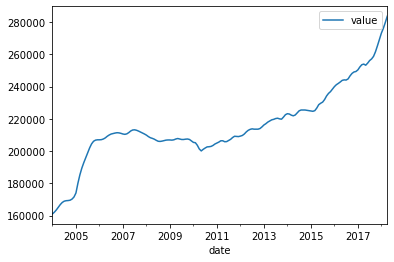

In [32]:
med_prices = df_prices.groupby('date').aggregate({'value':'median'})
med_prices.plot()

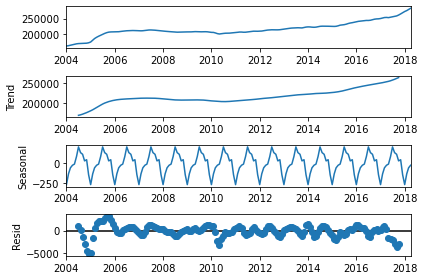

In [33]:
seasonal_med = seasonal_decompose(med_prices, model='additive')
seasonal_med.plot()
pyplot.show()

In [34]:
df_diff = df_prices.diff().dropna()

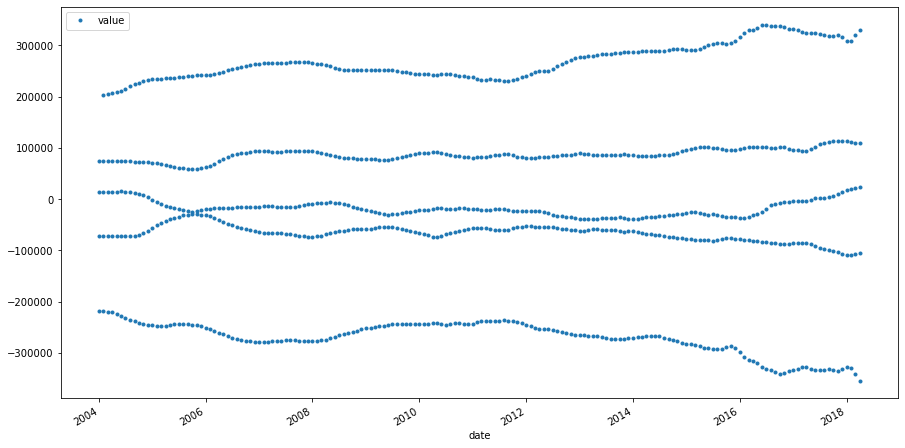

In [35]:
df_prices.diff().plot(figsize = (15, 8), style = '.');

In [36]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

Results of Dickey-Fuller Test: 

Test Statistic                   0.637108
p-value                          0.988495
#Lags Used                      19.000000
Number of Observations Used    840.000000
Critical Value (1%)             -3.438159
Critical Value (5%)             -2.864987
Critical Value (10%)            -2.568605
dtype: float64


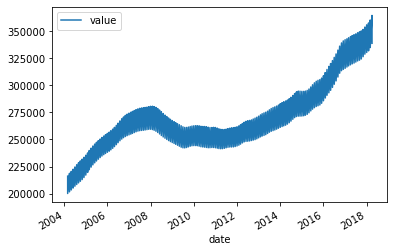

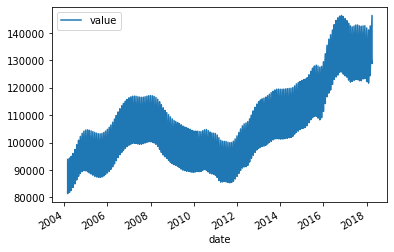

In [37]:
results = stationarity_check(df_prices)
results 

Results of Dickey-Fuller Test: 

Test Statistic                  -1.523481
p-value                          0.521865
#Lags Used                      18.000000
Number of Observations Used    840.000000
Critical Value (1%)             -3.438159
Critical Value (5%)             -2.864987
Critical Value (10%)            -2.568605
dtype: float64


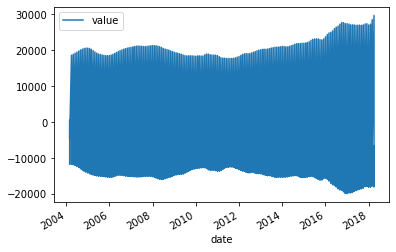

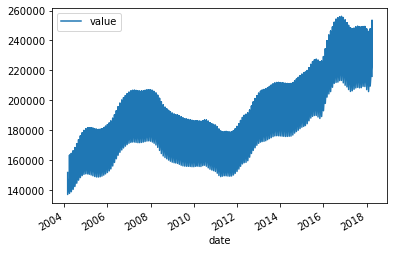

In [38]:
results = stationarity_check(df_diff)
results

<AxesSubplot:xlabel='date'>

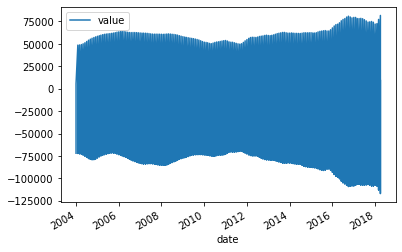

In [39]:
df_roll = df_prices.diff().rolling(3).mean()
df_roll.plot()

<ipython-input-40-5fd6d88f6e38>:1: RuntimeWarning: divide by zero encountered in log
  df_log = np.log(df_roll).dropna()
<ipython-input-40-5fd6d88f6e38>:1: RuntimeWarning: invalid value encountered in log
  df_log = np.log(df_roll).dropna()


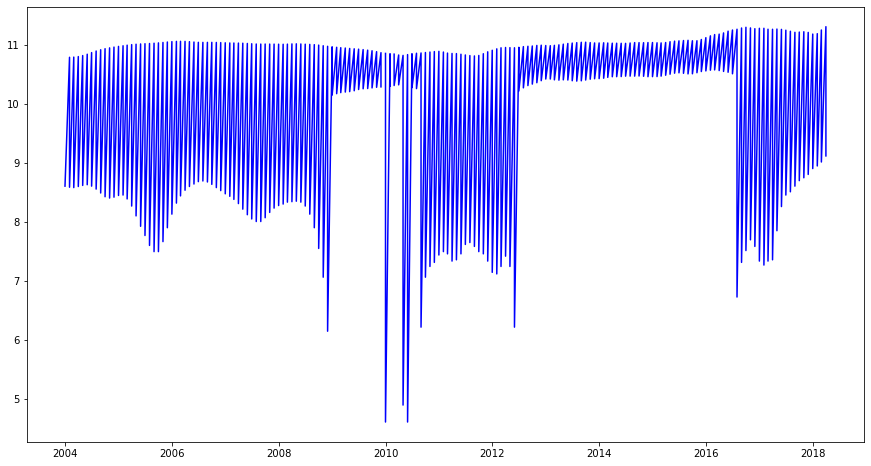

In [40]:
df_log = np.log(df_roll).dropna()
fig = plt.figure(figsize=(15,8))
plt.plot(df_log, color='blue');

In [41]:
results = stationarity_check(df_log)
results 

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/linalg/linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


MissingDataError: exog contains inf or nans

In [ ]:
weight_roll_mean = df_log.ewm(halflife=4).mean()
df_log_wrm = df_log - weight_roll_mean
df_log_wrm.plot(figsize=(15,8))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_log_wrm, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

In [ ]:
fig, ax = plt.subplots()

cmap = sns.cubehelix_palette(as_cmap=True)
points = ax.scatter(df_income['Longitude'], df_income['Latitude'], s=20, cmap='Blues')


ax.set_xlim((df_income['Longitude'].min(), df_income['Longitude'].max()))
ax.set_ylim((df_income['Latitude'].min(), df_income['Latitude'].max()))
fig.colorbar(points)
fig.set_size_inches(15,8)
plt.xlabel("Longitude")
plt.ylabel("Latitude");